In [1]:
import pandas as pd
import datetime
from datetime import timedelta
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import numpy as np
import requests
import urllib
from urllib.parse import urlencode
import json
plt.style.use('ggplot')

from tqdm.auto import tqdm
from scipy.stats import norm
from scipy import stats

## Начинаем изучение данных о регистрациях

In [34]:
df_reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kocharjan/shared/problem1-reg_data.csv', sep = ';')

In [35]:
df_reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [36]:
df_reg.dtypes

reg_ts    int64
uid       int64
dtype: object

In [37]:
df_reg.columns

Index(['reg_ts', 'uid'], dtype='object')

## Начинаем изучение данных о времени заходов пользователей

In [38]:
df_auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kocharjan/shared/problem1-auth_data.csv', sep = ';')

In [39]:
df_auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [40]:
df_auth.dtypes

auth_ts    int64
uid        int64
dtype: object

In [41]:
df_auth.columns

Index(['auth_ts', 'uid'], dtype='object')

In [42]:
#Приведем даты в данных к формату datetime
df_reg['reg_ts'] = pd.to_datetime(pd.to_datetime(df_reg.reg_ts, unit='s').dt.date)
df_auth['auth_ts'] = pd.to_datetime(pd.to_datetime(df_auth.auth_ts, unit='s').dt.date)

In [43]:
# Определим диапозон дат
df_reg['reg_ts'].agg(['min', 'max'])

min   1998-11-18
max   2020-09-23
Name: reg_ts, dtype: datetime64[ns]

In [44]:
df_auth['auth_ts'].agg(['min', 'max'])

min   1998-11-18
max   2020-09-23
Name: auth_ts, dtype: datetime64[ns]


# Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, 
которая будет считать retention игроков (по дням от даты регистрации игрока). 
Данные лежат в папке shared и имеют следующую структуру:

In [55]:
def ret_calc (df_reg, def_auth, start_date, end_date):
    '''
    df_reg: данные о регистрации пользователей
    df_auth: данные о ауторизации пользователей
    start_date: дата начала 
    end_date: дата окончания
    '''
    #Нужно перевести даты в формат datetime
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts']).dt.date
    df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts']).dt.date

    
    #Мердж датасетов по id пользователей (uid) 
    df_full_data = df_auth.merge(df_reg, on='uid')

    #ОСтаовяю только заданый период
    df_full_data = df_full_data.loc[(df_full_data.reg_ts >= start_date) & (df_full_data.auth_ts <= end_date)]

    #Количество дней после регистрации
    df_full_data['date_diff'] = (df_full_data.auth_ts - df_full_data.reg_ts).dt.days
    
    #Создаем сводную таблицу
    df_full_data_pivot = df_full_data.pivot_table(index='reg_ts', columns='date_diff', values='uid', aggfunc='nunique')
    
    #Создаем первый столбец 'day_0'
    day_0 = df_full_data_pivot.iloc[:, 0] 
    
    #Считам RR
    retention_rate = df_full_data_pivot.divide(day_0, axis=0)

    #Добавим визуализацию 
    plt.figure(figsize = (20, 15))
    plt.title('Retention c даты регистрации, %', fontsize=25)
    ax = sns.heatmap(retention_rate, vmin=0.0, vmax=0.12,
                cmap='Greens', linewidths=1, linecolor='white',
                fmt='.2%', annot=True)
    plt.ylabel('Дата регистрации', fontsize=25) 
    plt.xlabel('Дней после регистрации', fontsize=25)
    plt.show()

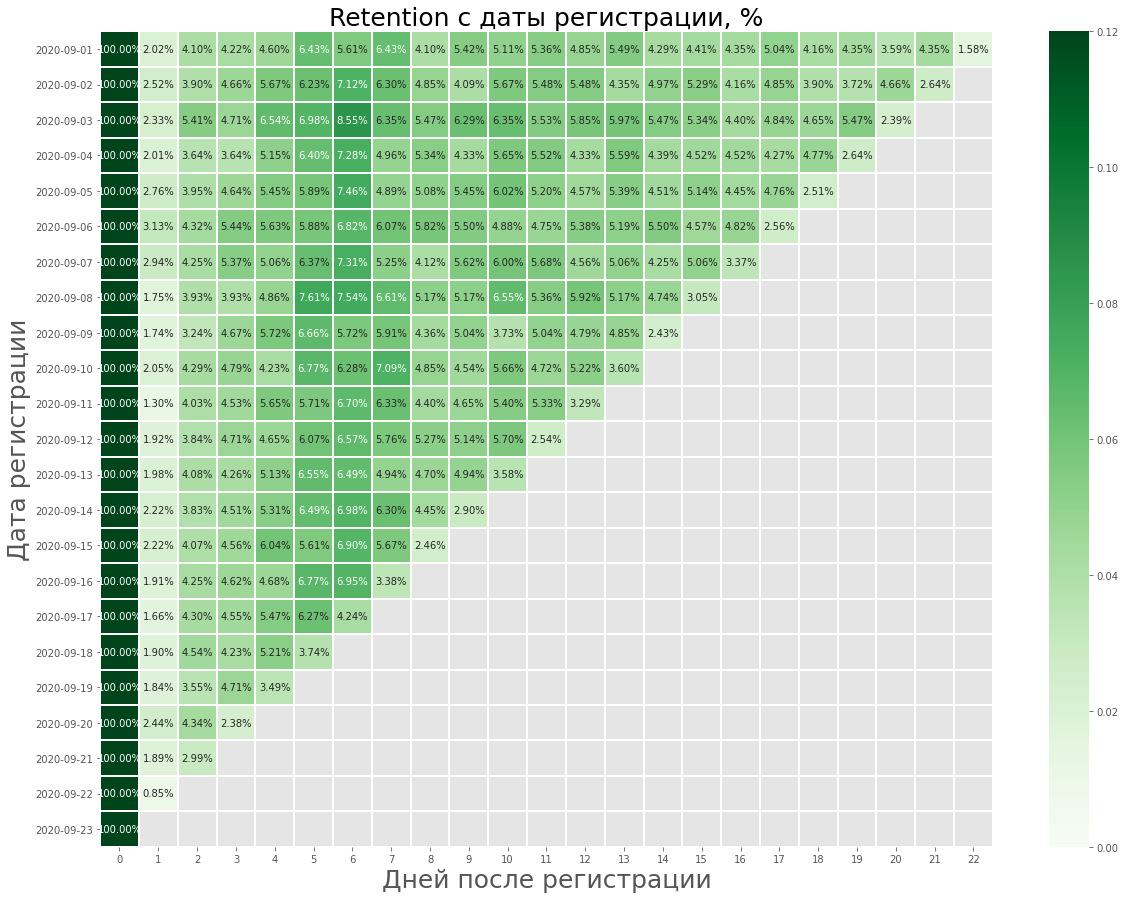

In [56]:
ret_calc(df_reg, df_auth, '2020-09-01', '2020-09-30')

# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [57]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-s-kocharjan/final_project/Проект_1_Задание_2.csv', sep=';')

In [58]:
df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [59]:
df.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [60]:
#Из условий задания  не известно, a или b контрольная/тестовая группа, нужно это выяснить
df_groups = df.groupby('testgroup', as_index=False) \
    .agg({'user_id':'count','revenue':'sum', }) \
    .rename(columns={'user_id':'total_users'})
df_groups

,testgroup,total_users,revenue
0,a,202103,5136189
1,b,202667,5421603


In [61]:
# Контрольная группа  - А , тестовая - В

In [62]:
#Найдем количество платящих пользователей
df_pay_u = df.query('revenue>0') \
    .groupby('testgroup', as_index=False)\
    .agg({'user_id':'count'}) \
    .rename(columns={'user_id':'pay_users'})
df_pay_u

,testgroup,pay_users
0,a,1928
1,b,1805


In [64]:
# Соединяем два датасета
df_full = df_groups.merge(df_pay_u, on='testgroup')
df_full

,testgroup,total_users,revenue,pay_users
0,a,202103,5136189,1928
1,b,202667,5421603,1805


In [65]:
# Рассчитываем метрики
df_full['ARPPU'] = df_full.revenue / df_full.pay_users
df_full['ARPU'] = df_full.pay_users / df_full.total_users * df_full.ARPPU
df_full['CR'] = df_full.pay_users / df_full.total_users
df_full

,testgroup,total_users,revenue,pay_users,ARPPU,ARPU,CR
0,a,202103,5136189,1928,2663.998444,25.413720,0.009540
1,b,202667,5421603,1805,3003.658172,26.751287,0.008906


In [68]:
# Проверим оба распределения на нормальность, для выбора метода оценки значимости

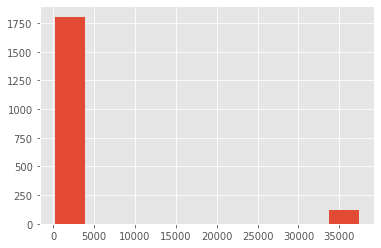

In [69]:
 a = df[(df.testgroup == 'a') & (df.revenue > 0)].revenue.hist()

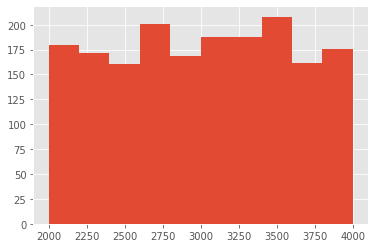

In [70]:
b = df[(df.testgroup == 'b') & (df.revenue > 0)].revenue.hist()

In [71]:
# МОжно наблюдать сильное различие характера распределения в группах

In [72]:
#Проверим нормальность распределения тестовых групп при помощи метода Шапиро (по 5000 рандомных выборок)

group_a = df.loc[df['testgroup'] == 'a'].sample(5000)
group_b = df.loc[df['testgroup'] == 'b'].sample(5000)

In [73]:
 stats.shapiro(x=group_a.revenue)

ShapiroResult(statistic=0.008958220481872559, pvalue=0.0)

In [74]:
 stats.shapiro(x=group_b.revenue)

ShapiroResult(statistic=0.06300175189971924, pvalue=0.0)

Как видно, что оба распрделения далеки от нормального. 
Используем методом bootstrap из лекций, для оценки полученых значений

In [75]:
# Функция из лекции

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [76]:
df_bootstrap = df.copy()

In [77]:
# ПРедлагаю оценить статистическую значимость для метрики ARPU 

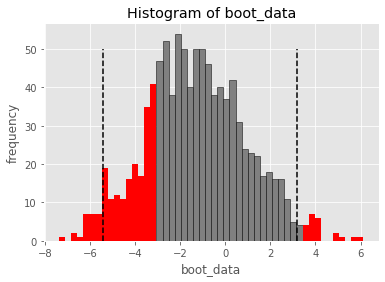

In [78]:
ARPU_bootstrap = get_bootstrap(df_bootstrap.query('testgroup == "a"').revenue,
                               df_bootstrap.query('testgroup == "b"').revenue,
                               boot_it = 1000, statistic = np.mean)

In [79]:
ARPU_bootstrap["p_value"]

0.5576348391920849

Ноль входит в доверительный интервал и значение p_value > 0.05 
значит нет поводов отклонять H0 Статзначимых различий не обнаружено

In [80]:
# Теперь оценим статистическую значимость для метрики ARPPU

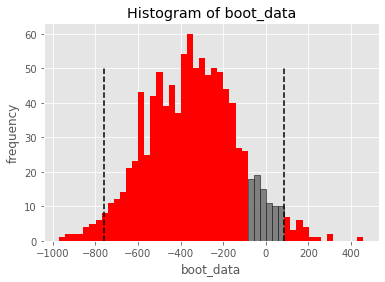

In [81]:
ARPPU_bootstrap = get_bootstrap(df_bootstrap.query('testgroup == "a" & revenue > 0').revenue, df_bootstrap.query('testgroup == "b" & revenue > 0').revenue,
                              boot_it = 1000, statistic = np.mean)

In [82]:
ARPPU_bootstrap["p_value"]

0.10831427026567696

Ноль входит в доверительный интервал и значение p_value > 0.05 
значит нет поводов отклонять H0 Статзначимых различий не обнаружено

In [84]:
# Теперь оценим CR для наших групп при помощи метода Хи-квадрата

In [85]:
#Сформируем перекрестную таблицу
df['CR'] = df.revenue.apply(lambda x: 'converted' if x > 0 else 'not_converted')
pd.crosstab(df.CR, df.testgroup)

testgroup,a,b
CR,,
converted,1928,1805
not_converted,200175,200862


In [86]:
#Применим метод Хи-квадрата
stat, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(df.CR, df.testgroup))
p

0.03647561892312613

Так как p-value < 0.05, то мы принимаем альтернативную гипотизу, что группы статистически значимо различаются

ВЫВОД: Были проанализированы метрики ARPU, ARPPU, CR. Статистически значимых отличий по метрикам ARPU и ARPPU не выявлено,но обнаружены статистически значимые различия между группами по метрике CR.

На основании полученных данных трудно дать однозначный ответ о успешности различных наборов акционных предложений. Исходя из разности в формировании групп, есть вероятность того, что была допущенна ошибка при их формировании.

# Задание 3 
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Для оценки результатов последнего прошедшего события в игре Plants & Gardens можно, например, использовать следующие метрики:
1. Количество участников события: позволяет оценить общий интерес игроков к событию.
2. Количество завершенных уровней: показывает, насколько успешно игроки прошли уровни и достигли целей события.
3. Количество полученных уникальных предметов или бонусов: отражает активность игроков и их мотивацию для участия в событии (эту метрику можно также разбить по показателю ценности "Добытых предметов", их значимости в рамках игры, например - обычные, редкие, супер артефакты).
4. Среднее время прохождения уровня: позволяет оценить сложность уровней и удовлетворенность игроков игровым процессом.
5. Конверсия завершения уровней: отношение количества игроков, завершивших все уровни, к общему числу участников.
6. Игровой опыт игрока за предыдущий период : позволит оценить, уровень "сложности" тематического события для прохождения игроками, сделать выводы о том, как расширить ЦА из общего числа игроков (например, упростив задания), а также определить уровень "лояльности" игрока.

Если в другом событии усложнена механика так, что при неудачной попытке игрок откатывается на несколько уровней назад, то набор метрик для оценки результатов может измениться:
1. Количество откатов: позволяет оценить, насколько часто игроки сталкиваются с откатом и как это влияет на их участие в событии.
2. Среднее количество уровней, на которые игрок откатывается: показывает степень сложности игрового процесса.
3. Количество игроков, покинувших событие после  отката: отражает уровень удовлетворенности игроков и их готовность продолжать участие в событии.
Данную метрику можно также разнообразить, подпунктами : количество игроков, покинувших игру после 1, 2,3... и т.д. откатов.
4. Конверсия завершения уровней после отката: отношение количества игроков, завершивших уровни после отката, к общему числу игроков, столкнувшихся с откатом.

Изменение механики события может повлиять на восприятие игроков, и поэтому важно адаптировать метрики оценки результатов события, чтобы учитывать новые условия и особенности игрового процесса.